**The purpose of this assignment is to apply convolution networks (convnets) to image data.**  

## As you saw in the chapter “Deep learning for computer vision,” convents can be used successfully to classify images. Specifically, consider the Cats & Dogs example. There were two broad approaches to classifying Cats & Dogs using convnets: Training a network from scratch, versus using a pretrained convnet. While small datasets can lead to overfitting, thus making training a network for prediction more difficult, you also saw several techniques to reduce overfitting, and these include data augmentation and regularization.   

##In this assignment, you will examine the relationship between training samples and the choice of training your model from scratch, versus using a pretrained convnet. 




> # Introduction to deep learning for computer vision



### Downloading the data

 Uploading the json file from kaggle to access the data from dogs-vs-cats dataset.

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sbandhan","key":"32f9cacea826fcefbe755a207aa34085"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats

 99% 804M/812M [00:03<00:00, 217MB/s]
100% 812M/812M [00:03<00:00, 228MB/s]


In [4]:
!unzip -qq dogs-vs-cats

In [5]:
!unzip -qq test1.zip

In [6]:
!unzip -qq train.zip

In [7]:
#shutil.rmtree("./cats_vs_dogs_small", ignore_errors=True)
#shutil.rmtree("./test1", ignore_errors=True)
#shutil.rmtree("./train", ignore_errors=True)


#1.Consider the Cats & Dogs example. Start initially with a training sample of 1000, a validation sample of 500, and a test sample of 500 (like in the text). Use any technique to reduce overfitting and improve performance in developing a network that you train from scratch. What performance did you achieve?  



#### Test Accuracy - 68.3%

#### Training Accuraccy - 98.25%

#### Validation Accuracy - 77%

**Copying images to training, validation, and test directories**

In [8]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)


# Training has 1000 samples, test has 500 samples and validation has 500 samples.

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)

# Data processing

Before being input into the model, the data is converted into preprocessed flaoting point tensors.
Because the data is in JPEG format, the preprocessing stages are as follows:
1.Read the pictures 
2. convert the JPEG content in to RGB  grid of pixels 
3.convert the RGB  grid of pixels in to floating point tensors
4. Resize them
5. Make them in to batches 

**Using `image_dataset_from_directory` to read images**

In [9]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Create a dataset instance from NumPy array of random numbers of 1000 samples and each sample of vector size 16

In [10]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [11]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


Batching the data into batches of size 32

In [12]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [13]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


**Displaying the shapes of the data and labels yielded by the `Dataset`**

In [14]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


##Building the model

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

**Configuring the model for training**

In [16]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

**Fitting the model using a `Dataset`**

In [18]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 20s 127ms/step - loss: 0.6942 - accuracy: 0.5110 - val_loss: 0.6899 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 7s 112ms/step - loss: 0.6934 - accuracy: 0.5135 - val_loss: 0.6906 - val_accuracy: 0.5440
Epoch 3/30
63/63 [==============================] - 8s 114ms/step - loss: 0.6892 - accuracy: 0.5025 - val_loss: 0.6826 - val_accuracy: 0.5370
Epoch 4/30
63/63 [==============================] - 7s 113ms/step - loss: 0.6778 - accuracy: 0.5735 - val_loss: 0.6786 - val_accuracy: 0.5740
Epoch 5/30
63/63 [==============================] - 7s 113ms/step - loss: 0.6404 - accuracy: 0.6455 - val_loss: 0.6413 - val_accuracy: 0.6440
Epoch 6/30
63/63 [==============================] - 7s 113ms/step - loss: 0.6172 - accuracy: 0.6560 - val_loss: 0.6235 - val_accuracy: 0.6540
Epoch 7/30
63/63 [==============================] - 7s 113ms/step - loss: 0.5996 - accuracy: 0.6800 - val_loss: 0.6048 - val_accuracy: 0.6820
Epoch

**Displaying curves of loss and accuracy during training**

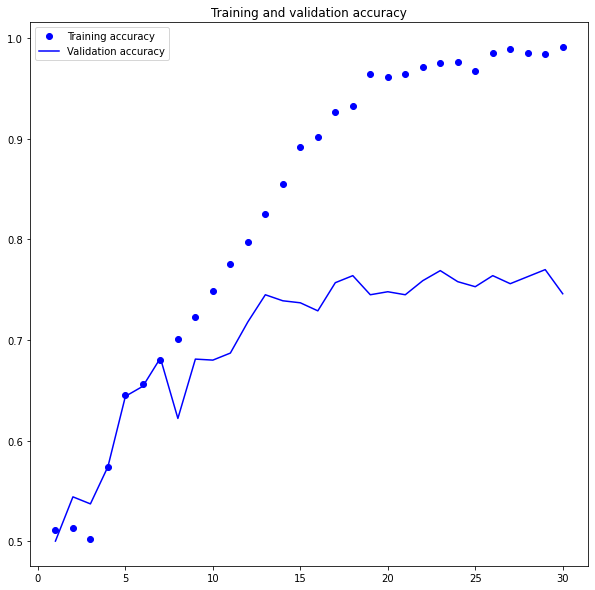

<Figure size 432x288 with 0 Axes>

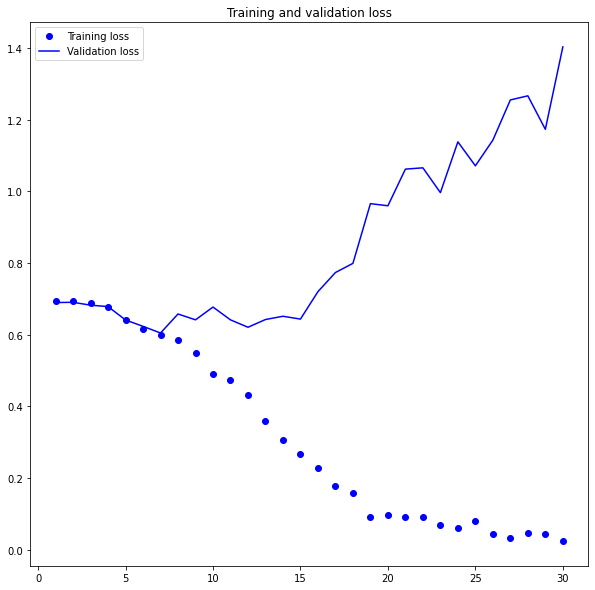

In [19]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.figure(figsize=(10, 10))
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [20]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 50ms/step - loss: 0.6072 - accuracy: 0.6830
Test accuracy: 0.683


From the above result we can conclude that the test accuracy is about 70.6% when the Training accuracy is about 98.75%.

# 2.Increase your training sample size. You may pick any amount. Keep the validation and test samples the same as above. Optimize your network (again training from scratch). What performance did you achieve?  

#### Test Accuracy - 78%

#### Training Accuraccy - 81.1%

#### Validation Accuracy - 83.1%


**Define a data augmentation stage to add to an image model**

In [21]:
import os, shutil, pathlib

shutil.rmtree("./cats_vs_dogs_small_Q2", ignore_errors=True)

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q2")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Creating training, Test and validation sets.
#Training has 1500 samples, test has 500 samples and validation has 500 samples.
make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2000)
make_subset("test", start_index=2000, end_index=2500)

In [22]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Displaying some randomly augmented training images**

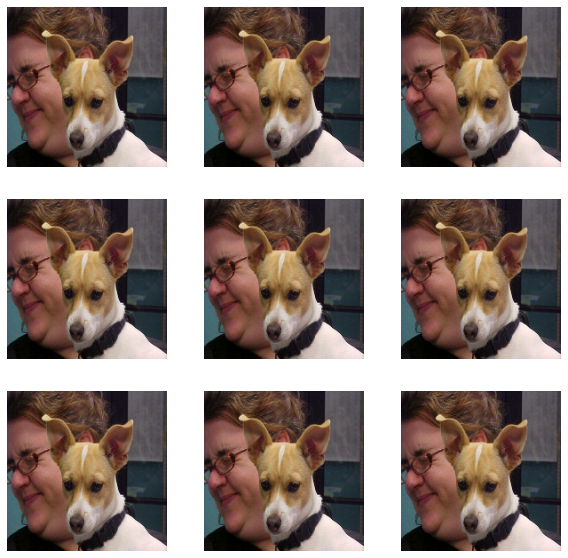

In [23]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Defining a new convnet that includes image augmentation and dropout**

In [24]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

**Training the regularized convnet**

In [25]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 10s 121ms/step - loss: 0.6950 - accuracy: 0.4915 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/50
63/63 [==============================] - 8s 119ms/step - loss: 0.6934 - accuracy: 0.5055 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 3/50
63/63 [==============================] - 8s 118ms/step - loss: 0.6939 - accuracy: 0.5110 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/50
63/63 [==============================] - 8s 118ms/step - loss: 0.6931 - accuracy: 0.4975 - val_loss: 0.6931 - val_accuracy: 0.5060
Epoch 5/50
63/63 [==============================] - 8s 119ms/step - loss: 0.6933 - accuracy: 0.4810 - val_loss: 0.6932 - val_accuracy: 0.4940
Epoch 6/50
63/63 [==============================] - 8s 119ms/step - loss: 0.6920 - accuracy: 0.5160 - val_loss: 0.6891 - val_accuracy: 0.5040
Epoch 7/50
63/63 [==============================] - 8s 119ms/step - loss: 0.6827 - accuracy: 0.5775 - val_loss: 0.6742 - val_accuracy: 0.5510
Epoch

**Evaluating the model on the test set**

In [26]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 48ms/step - loss: 0.4933 - accuracy: 0.7800
Test accuracy: 0.780


# 3.Now change your training sample so that you achieve better performance than those from Steps 1 and 2. This sample size may be larger, or smaller than those in the previous steps. The objective is to find the ideal training sample size to get best prediction results. 


#### Test Accuracy - 75.4%

#### Training Accuraccy - 78%

#### Validation Accuracy - 80%



**Increasing the training sample size to 2000 while maintaining the same validation and test sets  as before 500 samples**

In [27]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Creating training, Test and validation sets.
#Training has 2000 samples, test has 500 samples and validation has 500 samples.
make_subset("train", start_index=0, end_index=2000)
make_subset("validation", start_index=2000, end_index=2500)
make_subset("test", start_index=2500, end_index=3000)

**Creating  a new convnet with more training samples,image enhancement and dropuot**

In [28]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [29]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation1.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 9s 121ms/step - loss: 0.6983 - accuracy: 0.5135 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/50
63/63 [==============================] - 8s 118ms/step - loss: 0.6933 - accuracy: 0.5075 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 3/50
63/63 [==============================] - 8s 118ms/step - loss: 0.6933 - accuracy: 0.4990 - val_loss: 0.6915 - val_accuracy: 0.5680
Epoch 4/50
63/63 [==============================] - 8s 117ms/step - loss: 0.6924 - accuracy: 0.5190 - val_loss: 0.6981 - val_accuracy: 0.4980
Epoch 5/50
63/63 [==============================] - 8s 119ms/step - loss: 0.6950 - accuracy: 0.4890 - val_loss: 0.6913 - val_accuracy: 0.5440
Epoch 6/50
63/63 [==============================] - 8s 121ms/step - loss: 0.6895 - accuracy: 0.5255 - val_loss: 0.6902 - val_accuracy: 0.5260
Epoch 7/50
63/63 [==============================] - 8s 118ms/step - loss: 0.6883 - accuracy: 0.5345 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 

In [30]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation1.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 52ms/step - loss: 0.5222 - accuracy: 0.7540
Test accuracy: 0.754


**I began with the training a sample convnet on the 1,000 training samples with out any optimization to establish a base line ,which resulted in the classification accuracy was around 0.7780% and the Overfitting was recognized as the main problem Then i went through  data augmentation and other optimization strategies including earlystopping (determining the ideal number of epochs),Regularization,and drop out .Then i raised the model's accuracy to 0.786 by applying data augmentation.**


#After that i looked  for the best training sample to improve  classification accuracy
 The best approach  to avoid overfitting  have been discovered by manipulating the training sample  and using the optimization techniques

 1.Getting more training samples:It is not always practical to expand the training sample. Data Augmentation is one technique to make the most of the fewer training data.

 2.Reducing the capacity of the work:Overfitting is significantly reduced when the model's size is reduced, i.e. the number of learnable parameters in the model, which is effectively the number of layers and the number of units in layers.

3.Adding weight regularization:Limiting the complexity of a network by restricting the weights to accept only tiny values, which helps to regularize the distribution of the weight values and so prevents or minimizes overfitting.

4.Adding dropout:Overfitting is reduced by zeroing out a number of the layer's output characteristics during training. The percentage of features that are zeroed out is known as the dropout rate.

#4.Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in Steps 2 and 3 for the pretrained network may be the same or different from those using the network where you trained from scratch. Again, use any and all optimization techniques to get best performance.  

#** Using a pretrained model to apply deep learning to tiny image datasets is a highly effective method. A pretrained model is one that has been trained earlier on a big dataset, usually for a large-scale image classification problem.**
We will use a big convnet trained on the ImageNet dataset in this scenario (1.4 million labeled images and 1,000 different classes). We will use  the VGG16 architecture, although there are a variety of other architectures to choose from, including VGG, ResNet, Inception, Xception, and so on.

**Feature Extraction with a pretrained model**

Feature extraction is the process of extracting important features from new samples using the representations acquired by a previously trained model (in our instance, ImageNet). These characteristics are then fed into a new classifier that has been trained from the ground up.

**Instantiating the VGG16 convolutional base**

In [31]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58900480/58889256 [==============================] - 0s 0us/step


In [32]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

### Feature extraction without data augmentation using a pretrained model

**Extracting the VGG16 features and corresponding labels**

In [33]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

In [34]:
train_features.shape

(2000, 5, 5, 512)

**Defining and training the densely connected classifier**

In [35]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 2s 13ms/step - loss: 16.8442 - accuracy: 0.9295 - val_loss: 2.4309 - val_accuracy: 0.9740
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 3.8572 - accuracy: 0.9760 - val_loss: 8.7635 - val_accuracy: 0.9560
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 2.4812 - accuracy: 0.9835 - val_loss: 2.7485 - val_accuracy: 0.9750
Epoch 4/20
63/63 [==============================] - 1s 11ms/step - loss: 1.1347 - accuracy: 0.9895 - val_loss: 1.9847 - val_accuracy: 0.9820
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 1.6041 - accuracy: 0.9875 - val_loss: 7.2993 - val_accuracy: 0.9660
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 1.2773 - accuracy: 0.9925 - val_loss: 9.0656 - val_accuracy: 0.9630
Epoch 7/20
63/63 [==============================] - 1s 10ms/step - loss: 0.1468 - accuracy: 0.9965 - val_loss: 5.1295 - val_accuracy: 0.9810
Epoch 8/20
63

**Plotting the results**

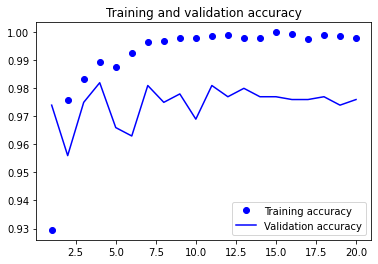

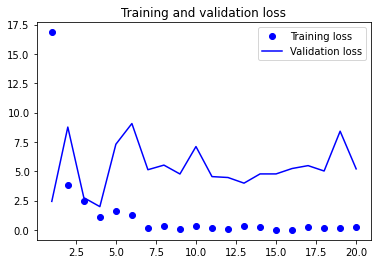

In [36]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#  Features extraction  with data agumentation using a pretrained model 

### Test Accuracy - 97.7%

### Validation Accuracy - 98.5%

### Training Accuracy - 98.9%

**Instantiating and freezing the VGG16 convolutional base**

In [37]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

**Printing the list of trainable weights before and after freezing**

In [38]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [39]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


**Adding a data augmentation stage and a classifier to the convolutional base**

In [40]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [41]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 24s 353ms/step - loss: 21.6438 - accuracy: 0.8905 - val_loss: 5.2440 - val_accuracy: 0.9720
Epoch 2/50
63/63 [==============================] - 22s 340ms/step - loss: 7.0660 - accuracy: 0.9490 - val_loss: 8.5745 - val_accuracy: 0.9520
Epoch 3/50
63/63 [==============================] - 22s 340ms/step - loss: 5.8796 - accuracy: 0.9515 - val_loss: 5.8756 - val_accuracy: 0.9710
Epoch 4/50
63/63 [==============================] - 22s 344ms/step - loss: 5.5211 - accuracy: 0.9595 - val_loss: 4.4857 - val_accuracy: 0.9730
Epoch 5/50
63/63 [==============================] - 22s 340ms/step - loss: 4.9671 - accuracy: 0.9620 - val_loss: 4.6937 - val_accuracy: 0.9770
Epoch 6/50
63/63 [==============================] - 22s 343ms/step - loss: 2.8346 - accuracy: 0.9780 - val_loss: 4.0841 - val_accuracy: 0.9760
Epoch 7/50
63/63 [==============================] - 22s 340ms/step - loss: 4.4121 - accuracy: 0.9655 - val_loss: 8.8625 - val_accuracy: 0.958

**Evaluating the model on the test set**

In [42]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 8s 216ms/step - loss: 2.3880 - accuracy: 0.9770
Test accuracy: 0.977


### A pretrained VGG16 model with Fine-tuning 

**Fine-tuning the model**
Fine-tuning involves unfreezing a few of the top layers of a frozen model base used for feature extraction and training both the newly added element of the model (in this case, the fully connected classifier) and these top layers at the same time. Fine-tuning is the process of slightly adjusting the more abstract representations of the model that are being reused to make them more relevant to the task at hand.

### test accuracy - 97.5%

### training accuracy - 98.01%

### validation accuracy - 99.00%


In [43]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

**Freezing all layers until the fourth from the last**

In [44]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**Fine-tuning the model**

In [45]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 26s 377ms/step - loss: 0.3570 - accuracy: 0.9930 - val_loss: 1.7360 - val_accuracy: 0.9880
Epoch 2/30
63/63 [==============================] - 24s 373ms/step - loss: 0.3190 - accuracy: 0.9925 - val_loss: 2.0822 - val_accuracy: 0.9820
Epoch 3/30
63/63 [==============================] - 24s 370ms/step - loss: 0.4510 - accuracy: 0.9905 - val_loss: 2.1986 - val_accuracy: 0.9770
Epoch 4/30
63/63 [==============================] - 24s 370ms/step - loss: 0.5700 - accuracy: 0.9875 - val_loss: 2.2732 - val_accuracy: 0.9770
Epoch 5/30
63/63 [==============================] - 23s 369ms/step - loss: 0.3730 - accuracy: 0.9890 - val_loss: 1.8103 - val_accuracy: 0.9800
Epoch 6/30
63/63 [==============================] - 24s 369ms/step - loss: 0.2126 - accuracy: 0.9945 - val_loss: 2.0494 - val_accuracy: 0.9790
Epoch 7/30
63/63 [==============================] - 24s 375ms/step - loss: 0.3888 - accuracy: 0.9905 - val_loss: 1.5445 - val_accuracy: 0.9820

In [46]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 7s 215ms/step - loss: 2.0073 - accuracy: 0.9750
Test accuracy: 0.975


## Summary

#using the  pre-trained model with out Augmentation 
we find that the validation accuracy of about it indicates that we were able to achieve an improvement from the above  when we started from the small scratch with the small model.and also when using pre-trained features,this isn't always the case.
Despite  employing a high rate of dropout ,the plots also show that we are overfitting nearly from the beginning.This is due to fact that this method does not employ data augmentation ,which is critical  for avoiding overfitting with the tiny images data set.
using the pre-trained model with augmentation
The accuracy of a model is always determined by the collection of samples used to test it! some samples sets may be more challenging than others, and good results on one set may not necessarily apply to all others .Pretrained model was created  as a result of it there was a small gain in accuracy with augmentation from 98% to - 99%

using pre-trained models with fine tuning 
we have  a test  accuracy of 97.5% in the case
With the one point range accuracy ,the accuracy results may varry